In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [3]:
from src.Evaluation.disco import disco_samples, p_noise
from src.utils.metrics import METRICS
import numpy as np
import matplotlib.pyplot as plt

METRICS["DISCO_non_noise"] = lambda X, l: np.mean(disco_samples(X, l)[l!=-1])
METRICS["DISCO_noise"] = lambda X, l: np.mean(disco_samples(X, l)[l==-1])
METRICS["DISCO_core_prop"] = lambda X, l: np.mean(p_noise(X, l)[0])
METRICS["DISCO_dc_prop"] = lambda X, l: np.mean(p_noise(X, l)[1])

for name in METRICS.keys():
    METRICS[name].__name__ = name

METRICS.keys()

dict_keys(['DISCO', 'DBCV', 'DCSI', 'LCCV', 'VIASCKDE', 'CVDD', 'CDBW', 'CVNN', 'SILHOUETTE', 'S_DBW', 'DISCO_non_noise', 'DISCO_noise', 'DISCO_core_prop', 'DISCO_dc_prop'])

In [4]:
from mpire.pool import WorkerPool
import warnings
warnings.filterwarnings("ignore")

def print_scores(X, l):

    def get_score(eval_metric):
        try:
            return f"{eval_metric.__name__}: {round(eval_metric(X, l), 2)}"
        except:
            pass

    pool = WorkerPool(20, use_dill=True)
    results = pool.imap(get_score, METRICS.values())
    # results = []
    for result in results:
        print(result)

In [18]:
import matplotlib.colors as mcolors
from src.utils.colors import colors

def plot_data(X, l, save_fig=None, save_format="png", show=True, cluster_marker_size=15, cluster_marker_density=1, noise_marker_size=80):
    fig = plt.figure()
    cmap = mcolors.ListedColormap([colors["purple"], colors["red"], colors["green"], colors["orange"]]) #colors["blue"]
    plt.scatter(
        X[:, 0][l != -1][::cluster_marker_density],
        X[:, 1][l != -1][::cluster_marker_density],
        s=cluster_marker_size,
        c=l[l != -1][::cluster_marker_density],
        vmin=-1,
        vmax=3,
        cmap=cmap,
    )
    plt.scatter(X[:, 0][l==-1], X[:, 1][l==-1], s=noise_marker_size, c=l[l==-1], vmin=-1, vmax=3, cmap=cmap, marker="1", alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    if save_fig:
        plt.savefig(f"imgs/motivation/{save_fig}.{save_format}", format=save_format, dpi=300, bbox_inches="tight", pad_inches=0
        )
    if show:
        plt.show()
    return fig

In [6]:
# from datasets.density_datasets import Datasets as DensityDatasets

# X, l = DensityDatasets.dartboard1.standardized_data_cached

n_points per cluster: [100, 300, 500]
(900, 2) (900,)


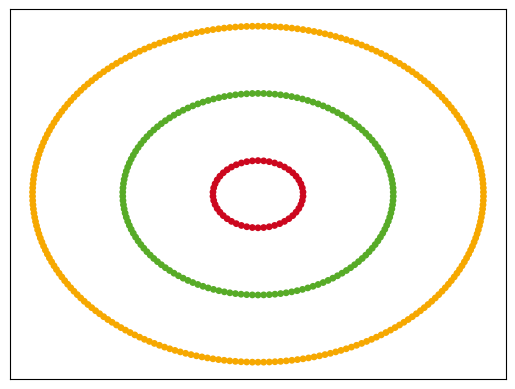

DISCO: 0.94
DBCV: 0.99
DCSI: 1.0
LCCV: 0.61
VIASCKDE: nan
CVDD: 19964.06
CDBW: 0.0
CVNN: 58.43
SILHOUETTE: -0.12
S_DBW: 0.97
DISCO_non_noise: 0.94
DISCO_noise: nan
DISCO_core_prop: nan
DISCO_dc_prop: nan


In [7]:
import math

# radii = [5,10,15,20]
# n_points_per_cluster = [100,200,300,400]
radii = [5, 15, 25]
n_points_per_cluster = [100, 300, 500]

X = np.array(
    [
        [math.sin((2 * math.pi / n_points) * i) * radius, math.cos((2 * math.pi / n_points) * i) * radius]
        for radius, n_points in zip(radii, n_points_per_cluster)
        for i in range(n_points)
    ]
)
l = np.array(sum([[c] * n_points for c, n_points in enumerate(n_points_per_cluster)], []))

print("n_points per cluster:", [len(l[l == i]) for i in set(l)])
print(X.shape, l.shape)

plot_data(X, l, save_fig="motivation_dartboard")
print_scores(X, l)

(900, 2) (900,)


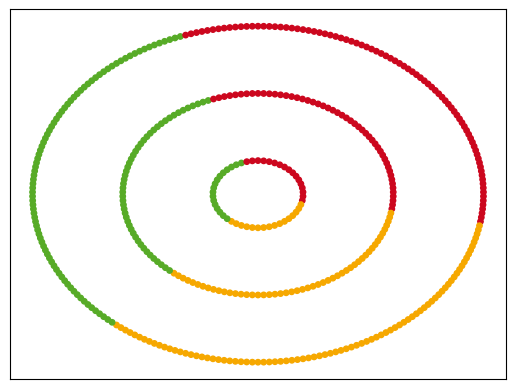

DISCO: -0.0
DBCV: -0.96
DCSI: 0.0
LCCV: 0.14
VIASCKDE: 0.11
CVDD: 0.19
CDBW: 0.0
CVNN: 49.61
SILHOUETTE: 0.38
S_DBW: 0.63
DISCO_non_noise: -0.0
DISCO_noise: nan
DISCO_core_prop: nan
DISCO_dc_prop: nan


In [8]:
from sklearn.cluster import KMeans
np.random.seed(0)
l_kmeans = KMeans(3).fit_predict(X)

print(X.shape, l_kmeans.shape)

plot_data(X, l_kmeans, save_fig="motivation_dartboard_kmeans")
print_scores(X, l_kmeans)

In [11]:
np.random.seed(0)
X_noise, l_noise = add_noise(X, l, 300, 1.6, 0.6)

np.random.seed(0)
X_noise_, l_noise_ = add_noise(X, l, 300, 1.6, 0.6)

(1200, 2) (1200,)


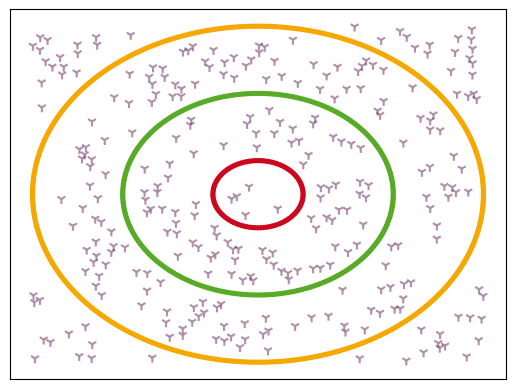

DISCO: 0.72
DBCV: 0.74
DCSI: 1.0
LCCV: 0.58
VIASCKDE: 0.01
CVDD: 834.37
CDBW: 0.0
CVNN: 58.43
SILHOUETTE: -0.16
S_DBW: 0.97
DISCO_non_noise: 0.72
DISCO_noise: 0.74
DISCO_core_prop: 0.74
DISCO_dc_prop: 0.75


In [30]:
from src.utils.data import add_noise

np.random.seed(0)
X_noise, l_noise = add_noise(X, l, 300, 1.6, 0.6)
# X_noise, l2 = add_noise(X, l1, 70, 0.15, 0.07)

print(X_noise.shape, l_noise.shape)

plot_data(X_noise, l_noise, save_fig="motivation_dartboard_noise", cluster_marker_size=8, noise_marker_size=50)
print_scores(X_noise, l_noise)

In [28]:
from src.utils.metrics import DBCV

np.random.seed(42)


def shuffle(X, l):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], l[idx]


dbcv_values = np.array([DBCV(*shuffle(X_noise, l_noise)) for _ in range(15)])
dbcv_values.mean(), dbcv_values.std()

(0.740300709831083, 2.0471501066083614e-16)

(1200, 2) (1200,)


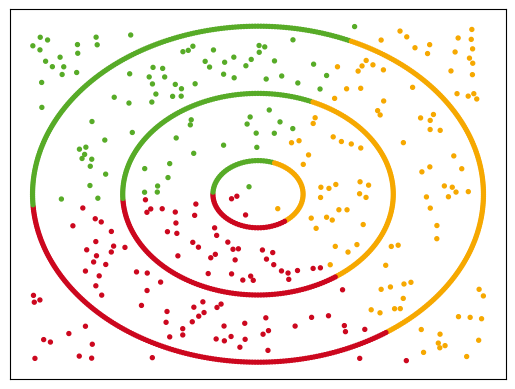

DISCO: -0.01
DBCV: -0.91
DCSI: 0.0
LCCV: 0.1
VIASCKDE: 0.68
CVDD: 0.52
CDBW: 0.0
CVNN: 50.12
SILHOUETTE: 0.37
S_DBW: 0.73
DISCO_non_noise: -0.01
DISCO_noise: nan
DISCO_core_prop: nan
DISCO_dc_prop: nan


In [27]:
from src.utils.data import add_noise
from sklearn.cluster import KMeans

np.random.seed(0)
# X_noise, l_noise = add_noise(X, l, 300, 1.6, 0.6)
# X_noise, l2 = add_noise(X, l1, 70, 0.15, 0.07)
l_kmeans = KMeans(3).fit_predict(X_noise)

print(X_noise.shape, l_kmeans.shape)

plot_data(X_noise, l_kmeans, save_fig="motivation_dartboard_noise_kmeans", cluster_marker_size=8)
print_scores(X_noise, l_kmeans)

In [29]:
from src.utils.metrics import DBCV

np.random.seed(42)


def shuffle(X, l):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], l[idx]


dbcv_values = np.array([DBCV(*shuffle(X_noise, l_kmeans)) for _ in range(15)])
dbcv_values.mean(), dbcv_values.std()

(-0.9464136280678506, 0.007556487992024845)

(1300, 2) (1300,)


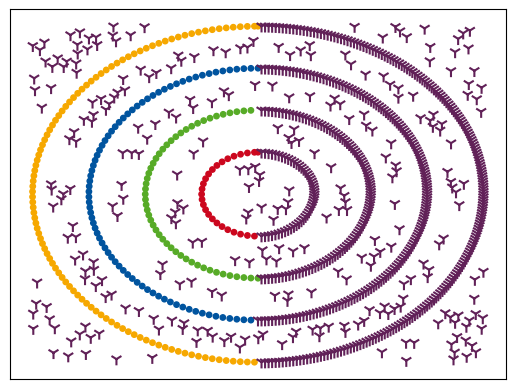

In [169]:
l_right_noise = l_noise.copy()
idx = np.where(X[:, 0] > 0)[0]
l_right_noise[idx] = -1

print(X_noise.shape, l_right_noise.shape)

plot_data(X_noise, l_right_noise, save_fig="dartboard_noise_split")
print_scores(X_noise, l_right_noise)

(1300, 2) (1300,)


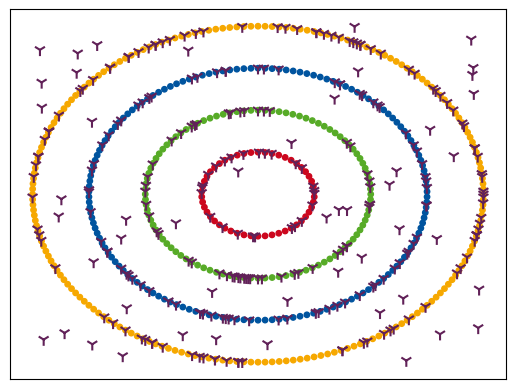

In [155]:
import math
from functools import reduce
np.random.seed(200)

r = np.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)
radii = np.unique(np.round(r))

n_noise_list = reduce(lambda list, elem: list + [list[-1] + list[0]], range(3), [25])
n_noise = sum(n_noise_list, 0)
l_circle_noise = sum([[i] * n_noise for i, n_noise in enumerate(n_noise_list)], [])

angles = np.random.choice(360, size=n_noise, replace=True).astype(float)
angles *= (2 * math.pi / 360)

X_circle_noise = np.array(
    [[math.sin(angle) * radii[id], math.cos(angle) * radii[id]] for id, angle in zip(l_circle_noise, angles)]
)

X_n_circ = X.copy()
X_n_circ = np.vstack((X_n_circ, X_circle_noise))

l_n_circ = l.copy()
l_n_circ = np.hstack((l_n_circ, np.array([-1] * n_noise)))

from src.utils.data import add_noise
np.random.seed(0)
X_n_circ, l_n_circ = add_noise(X_n_circ, l_n_circ, 50, 1.6, 0.6)

print(X_n_circ.shape, l_n_circ.shape)

plot_data(X_n_circ, l_n_circ, save_fig="dartboard_noise_on_circle")
print_scores(X_n_circ, l_n_circ)

(1300, 2) (1300,)


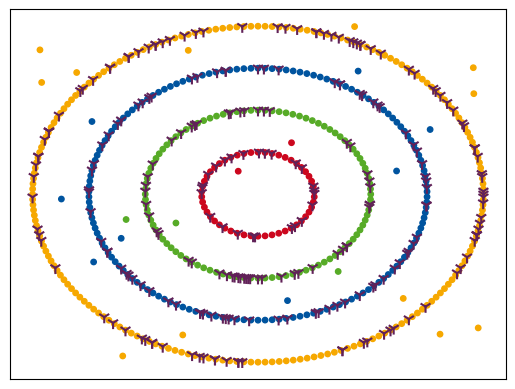

In [156]:
from sklearn.neighbors import NearestNeighbors

data = X_n_circ[-50:]

nbrs = NearestNeighbors(n_neighbors=1).fit(X)
_, idx = nbrs.kneighbors(data)
l_n_cirl_nn = l_n_circ.copy()
l_n_cirl_nn[-50:] = l[idx].flatten()

print(X_n_circ.shape, l_n_cirl_nn.shape)

plot_data(X_n_circ, l_n_cirl_nn, save_fig="dartboard_noise_on_circle_nn")
print_scores(X_n_circ, l_n_cirl_nn)

(1300, 2) (1300,)


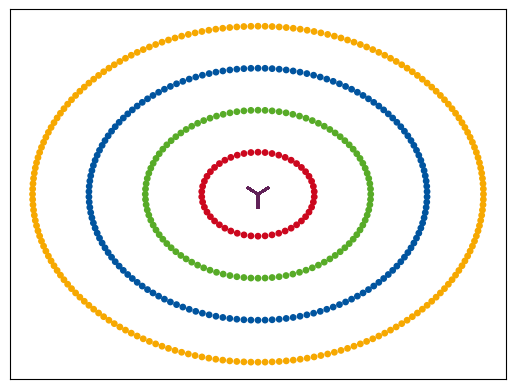

In [157]:
X_noise_c = X_noise.copy()
X_noise_c[-300:] = [0, 0]

print(X_noise_c.shape, l_noise.shape)

plot_data(X_noise_c, l_noise, save_fig="dartboard_noise_center", noise_marker_size=400)
print_scores(X_noise_c, l_noise)

(1300, 2) (1300,)


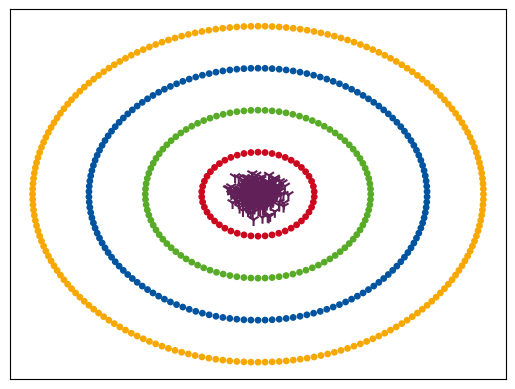

In [158]:
from sklearn.datasets import make_blobs

noise_blob = make_blobs(centers=[[0, 0]], n_samples=300, random_state=0)
noise_blob[0]
X_noise_c = X_noise.copy()
X_noise_c[-300:] = noise_blob[0]

print(X_noise_c.shape, l_noise.shape)

plot_data(X_noise_c, l_noise, save_fig="dartboard_noise_center_blob")
print_scores(X_noise_c, l_noise)

(1300, 2) (1300,)


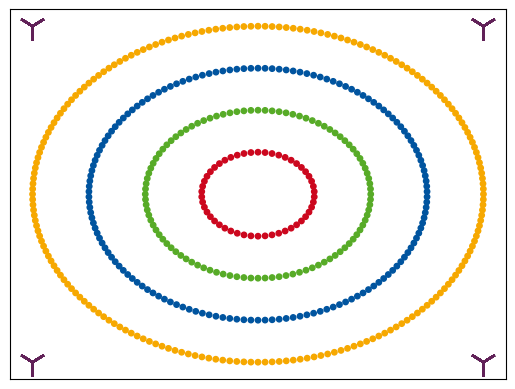

In [159]:
X_noise_at_corner = X_noise.copy()
X_noise_at_corner[-75 * 4 : -75 * 3] = [20, 20]
X_noise_at_corner[-75 * 3 : -75 * 2] = [-20, 20]
X_noise_at_corner[-75 * 2 : -75 * 1] = [20, -20]
X_noise_at_corner[-75 * 1 :] = [-20, -20]

print(X_noise_at_corner.shape, l_noise.shape)

plot_data(X_noise_at_corner, l_noise, save_fig="dartboard_noise_corner", noise_marker_size=400)
print_scores(X_noise_at_corner, l_noise)

(1300, 2) (1300,)


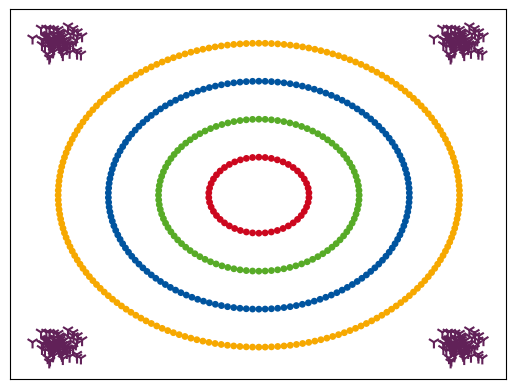

In [160]:
from sklearn.datasets import make_blobs

noise_blob = make_blobs(centers=[[20, 20]], n_samples=75, random_state=0)[0]
noise_blob[0]

X_noise_at_corner = X_noise.copy()
X_noise_at_corner[-75 * 4 : -75 * 3] = make_blobs(centers=[[20, 20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 3 : -75 * 2] = make_blobs(centers=[[-20, 20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 2 : -75 * 1] = make_blobs(centers=[[20, -20]], n_samples=75, random_state=0)[0]
X_noise_at_corner[-75 * 1 :] = make_blobs(centers=[[-20, -20]], n_samples=75, random_state=0)[0]

print(X_noise_at_corner.shape, l_noise.shape)

plot_data(X_noise_at_corner, l_noise, save_fig="dartboard_noise_corner_blob")
print_scores(X_noise_at_corner, l_noise)

(1300, 2) (1300,)


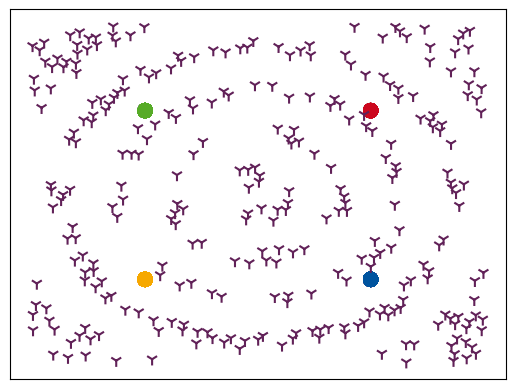

In [161]:
X_at_corner = X_noise.copy()
X_at_corner[:100] = [10, 10]
X_at_corner[100:300] = [-10, 10]
X_at_corner[300:600] = [10, -10]
X_at_corner[600:1000] = [-10, -10]
# X_at_corner[:] = [0,0]

print(X_at_corner.shape, l_noise.shape)

plot_data(X_at_corner, l_noise, save_fig="dartboard_quadrat", cluster_marker_size=100)
print_scores(X_at_corner, l_noise)

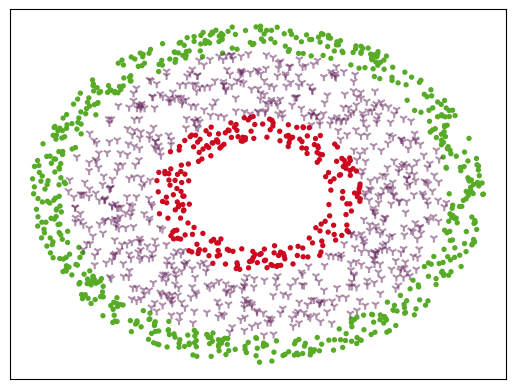

DISCO: 0.88
DBCV: 0.86
DCSI: 0.98
LCCV: 0.61
VIASCKDE: 0.09
CVDD: 751.64
CDBW: 0.0
CVNN: 22.39
SILHOUETTE: 0.01
S_DBW: 0.98
DISCO_non_noise: 0.88
DISCO_noise: nan
DISCO_core_prop: nan
DISCO_dc_prop: nan
DISCO: 0.03
DBCV: 0.61
DCSI: 0.98
LCCV: -0.03
VIASCKDE: 0.07
CVDD: 42.32
CDBW: 0.0
CVNN: 22.36
SILHOUETTE: -0.07
S_DBW: 0.98
DISCO_non_noise: 0.15
DISCO_noise: -0.26
DISCO_core_prop: -0.26
DISCO_dc_prop: -0.16


In [109]:
np.random.seed(42^7)

def add_donut(n_points, inner_radius, outer_radius):
    data = np.empty((n_points, 2))
    data_too_near = np.array(range(len(data)))
    while len(data_too_near) > 0:
        data[data_too_near] = np.random.uniform(-outer_radius, outer_radius, size=(len(data_too_near), X.shape[1]))
        dists_points = np.sqrt(data[:,0]**2 + data[:, 1]**2)
        data_too_near = np.where((dists_points > outer_radius) | (dists_points < inner_radius))[0]
    return data

X_donut_0 = add_donut(500, 4, 6)
X_donut_noise = add_donut(700, 6.1, 10.9)
X_donut_1 = add_donut(1200, 11, 13)

X_donut = np.vstack((X_donut_0, X_donut_noise, X_donut_1))
l_donut = np.array([0] * len(X_donut_0) + [-1] * len(X_donut_noise) + [1] * len(X_donut_1))

# dists_points = np.sqrt(data[:,0]**2 + data[:, 1]**2)
# 0: 4 - 7, noise: 7-10, 1: 10-13
# l_donut[np.where((dists_points < 7))[0]] = 0
# l_donut[np.where((dists_points > 10))[0]] = 1

fig = plot_data(X_donut, l_donut, save_fig="motivation_donut_noise", cluster_marker_size=8, noise_marker_size=40)
print_scores(X_donut[l_donut != -1], l_donut[l_donut != -1])
print()
print_scores(X_donut, l_donut)

In [74]:
from src.utils.metrics import DBCV

np.random.seed(42)

def shuffle(X, l):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], l[idx]

dbcv_values = np.array([DBCV(*shuffle(X_donut, l_donut)) for _ in range(15)])
dbcv_values.mean(), dbcv_values.std()

(0.6400875743664037, 0.01058920778876645)

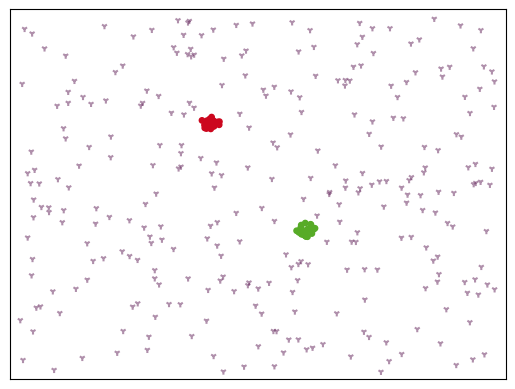

DISCO: 0.98
DBCV: 1.0
DCSI: 1.0
LCCV: 0.55
VIASCKDE: 0.09
CVDD: 792.01
CDBW: 0.94
CVNN: 4.53
SILHOUETTE: 0.95
S_DBW: 0.08
DISCO_non_noise: 0.98
DISCO_noise: nan
DISCO_core_prop: nan
DISCO_dc_prop: nan

DISCO: 0.81
DBCV: 0.25
DCSI: 1.0
LCCV: 0.26
VIASCKDE: nan
CVDD: 16.48
CDBW: 0.94
CVNN: 4.53
SILHOUETTE: -0.08
S_DBW: 0.08
DISCO_non_noise: 0.9
DISCO_noise: 0.79
DISCO_core_prop: 0.79
DISCO_dc_prop: 0.83


In [32]:
# Good Noise

import numpy as np
from sklearn.neighbors import NearestNeighbors

def add_noise_(X, l, n_noise, eps, noise_eps, border=0):
    """Add noise to data with at least eps distance to the data."""

    noise = np.empty((n_noise, X.shape[1]))
    noise_too_near = np.array(range(len(noise)))
    while len(noise_too_near) > 0:
        noise[noise_too_near] = np.random.uniform(-50, 50, size=(len(noise_too_near), X.shape[1]))
        nbrs_points = NearestNeighbors(n_neighbors=1).fit(X)
        dists_points = nbrs_points.kneighbors(noise)[0]
        noise_too_near_points = np.where(dists_points < eps)[0]
        nbrs_noise = NearestNeighbors(n_neighbors=2).fit(noise)
        dists_noise = nbrs_noise.kneighbors(noise)[0][:, 1]
        noise_too_near_noise = np.where(dists_noise < noise_eps)[0]
        noise_too_near = np.unique(np.hstack((noise_too_near_points, noise_too_near_noise)))

    X_ = np.vstack((X, noise))
    l_ = np.hstack((l, np.array([-1] * len(noise))))

    return X_, l_


def make_blob_and_noise_dist_uniform(n_samples, n_noise=0, seed=0):
    np.random.seed(seed)
    n_samples = n_samples
    centers = np.array([[-10, 20], [10, -10]])
    X = np.empty((0, 2))
    l = np.empty((0))
    for i, center in enumerate(centers):
        X_i = np.empty((0, 2))
        while len(X_i) < n_samples:
            X_i_ = np.random.uniform(low=center - 2, high=center + 2, size=(n_samples * 10, 2))
            X_i_mask = np.linalg.norm(X_i_ - center, axis=1) <= 2
            X_i_ = X_i_[X_i_mask]
            X_i = np.vstack((X_i, X_i_[: min(n_samples - len(X_i), len(X_i_))]))
        X = np.vstack((X, X_i))
        l = np.hstack((l, np.array([i] * len(X_i))))
    X, l = add_noise_(X, l, n_noise, 2, 0.5, border=5)
    return X, l


X, l = make_blob_and_noise_dist_uniform(50, n_noise=300)

fig = plot_data(X, l, save_fig="motivation_background_noise", noise_marker_size=20, show=False, cluster_marker_density=2)
ax = fig.gca()
ax.set_xlim(-52, 52)
ax.set_ylim(-52, 52)
plt.savefig(f"imgs/motivation/{"motivation_background_noise"}.{"png"}", format="png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
print_scores(X[l != -1], l[l != -1])
print()
print_scores(X, l)

In [107]:
from src.utils.metrics import DBCV

np.random.seed(42)

def shuffle(X, l):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    return X[idx], l[idx]


dbcv_values = np.array([DBCV(*shuffle(X, l)) for _ in range(15)])
dbcv_values.mean(), dbcv_values.std()

(0.24980638041236203, 8.44087909835249e-06)

In [77]:
!ls -lh imgs/motivation/motivation*

-rw------- 1 pascalw777dm dm_users 484K Jan 23 14:49 imgs/motivation/motivation_background_noise.png
-rw------- 1 pascalw777dm dm_users 119K Jan 23 14:48 imgs/motivation/motivation_dartboard_kmeans.png
-rw------- 1 pascalw777dm dm_users 188K Jan 23 14:48 imgs/motivation/motivation_dartboard_noise_kmeans.png
-rw------- 1 pascalw777dm dm_users 291K Jan 23 14:48 imgs/motivation/motivation_dartboard_noise.png
-rw------- 1 pascalw777dm dm_users 116K Jan 23 14:48 imgs/motivation/motivation_dartboard.png
-rw------- 1 pascalw777dm dm_users 516K Jan 23 14:48 imgs/motivation/motivation_donut_noise.png
